In [1]:
import os
import os.path as osp
import re

import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from scipy.spatial import KDTree

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Dataset, Data

In [2]:
# check for valid spline_conv
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")

# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define a function to check if a point is on a line segment between two other points
def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Calculate vectors
    pq = q - p
    pr = r - p
    
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(pq, pr), 0, atol=tolerance)
    if not collinear.all():  # Ensure all collinearity conditions are met
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

# Define a function to hash points into a grid for spatial organization
def grid_hash(points, grid_size=1.0):
    grid = defaultdict(list)
    # Assign each point to a grid cell
    for idx, point in enumerate(points):
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

# Define a function to find points near a given line segment for further processing
def get_nearby_points(p, q, grid, points, grid_size=1.0):
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))
    nearby_points = []
    # Collect all points within the bounding box of the segment pq
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

# Define a function to split edges based on the spatial proximity of nodes
def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    p, q = edge
    split_points = [p]
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            split_points.append(r)
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

# Main function to read and process mesh data from a VTK file
def read_mesh_cellCon(filename, grid_size=1.0, verbose=1.0):
    """Reads and processes mesh data from a VTK file, ignoring z-coordinates."""
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the start and end of the points section
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points
    
    # Extract points, ignoring z coordinates if present
    raw_points = [list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_end]]
    raw_points = np.array(raw_points)
    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Parse scalar fields and handle duplicates by taking the maximum value
    scalar_fields = {}
    i = points_end
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            field_name = lines[i].split()[1]
            lookup_table_start = i + 2  # Points to the start of scalar values
            values = [float(line.strip()) for line in lines[lookup_table_start:lookup_table_start + num_points]]
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points
        else:
            i += 1

    # Deduplicate scalar fields by taking the maximum value
    deduplicated_data = {name: np.full(len(unique_points), -np.inf) for name in scalar_fields}
    for name, data in scalar_fields.items():
        for i, idx in enumerate(indices):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], data[i])

    # Extract elements and compute edge attributes
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells
    elements = [list(map(int, line.strip().split()))[1:] for line in lines[cells_start + 1:cells_end]]
    elements = [indices[element] for element in elements]

    grid = grid_hash(unique_points, grid_size)
    edges = set()
    for element in elements:
        for i in range(len(element)):
            a, b = sorted([element[i], element[(i + 1) % len(element)]])
            edges.add((a, b))

    # Split and process edges based on proximity
    new_edges = set()
    total_edges = len(edges)
    for i, edge in enumerate(edges):
        split_edges = split_edge_by_nodes(edge, unique_points, grid, grid_size)
        new_edges.update(split_edges)

    # Compute edge distances for attributes
    edge_attributes = [{'node1': a, 'node2': b, 'distance': np.sqrt((unique_points[a] - unique_points[b]) ** 2)} for a, b in new_edges]

    return unique_points, deduplicated_data, elements, pd.DataFrame(edge_attributes)

# Example of how to use the function
# filename = './dataset/NDD/physics_allparticle_001200.vtk'
# unique_points, scalar_fields, edges, edge_attributes = read_mesh(filename)
# print("Points:", unique_points)
# print("Scalar Fields:", scalar_fields)
# print("Edges:", len(edges))
# print("Edge Attributes:", edge_attributes[:5])


In [4]:
def grid_hash(points, grid_size=1.0):
    """
    Hashes points into a spatial grid. Each point is assigned to a grid cell, facilitating
    quick spatial queries like proximity checks.

    Args:
        points (array): Array of point coordinates.
        grid_size (float): Dimension size of each grid cell.

    Returns:
        dict: A dictionary where keys are grid cell coordinates and values are lists of point indices in those cells.
    """
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        # Calculate grid cell coordinates based on the point location and grid size.
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def connect_points_in_zone(grid, grid_size=1.0):
    """
    Connects points within the same or adjacent grid cells to form edges, based on their spatial proximity.

    Args:
        grid (dict): A dictionary from grid_hash function mapping grid cells to point indices.
        grid_size (float): The size of each grid cell used in the hashing process.

    Returns:
        set: A set of tuples, each representing an edge between two points.
    """
    edges = set()
    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    for key in grid:
        for offset in neighbor_offsets:
            neighbor_key = (key[0] + offset[0], key[1] + offset[1])
            if neighbor_key in grid:
                # Check all points in the current cell against points in the neighboring cell
                for src in grid[key]:
                    for dest in grid[neighbor_key]:
                        if src != dest:
                            edges.add(tuple(sorted([src, dest])))
    return edges

def read_mesh_allCon(filename, grid_size=1.0):
    """
    Reads a VTK file and processes it to extract points, compute spatial connectivity,
    and extract scalar fields. Redefines connectivity based on spatial proximity.

    Args:
        filename (str): Path to the VTK file.
        grid_size (float): Size of the grid cell for spatial hashing.

    Returns:
        tuple: Contains arrays of unique points, deduplicated scalar data, edge list, and edge attributes.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points = np.array([list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_start + 1 + num_points]])

    # Remove duplicates and create spatial hash grid
    unique_points, inverse_indices = np.unique(points, axis=0, return_inverse=True)
    grid = grid_hash(unique_points, grid_size)

    # Compute spatially based edges
    edges = connect_points_in_zone(grid, grid_size)

    # Initialize scalar fields
    scalar_fields = {}
    i = points_start + num_points + 1
    while i < len(lines):
        if 'SCALARS' in lines[i] and 'LOOKUP_TABLE' in lines[i+1]:
            field_name = lines[i].split()[1]
            scalar_values = []
            start = i + 3
            end = min(start + num_points, len(lines))
            for j in range(start, end):
                try:
                    scalar_values.append(float(lines[j].strip()))
                except ValueError:
                    continue
            scalar_fields[field_name] = np.array(scalar_values)
            i = end
        else:
            i += 1

    # Map scalar values to unique points and take maximum values instead of averaging
    deduplicated_data = {name: np.full(len(unique_points), -np.inf) for name in scalar_fields}  # Initialize with negative infinity
    for name, data in scalar_fields.items():
        for idx, value in zip(inverse_indices, data):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], value)  # Take max

    # Prepare edge attributes (e.g., distance)
    edge_attributes = [{'node1': a, 'node2': b, 'distance': np.linalg.norm(unique_points[a] - unique_points[b])} for a, b in edges]

    return unique_points, deduplicated_data, edges, edge_attributes

# Example usage:
# filename = './dataset/NDD/physics_allparticle_001200.vtk'
# unique_points, scalar_fields, edges, edge_attributes = read_mesh_allCon(filename)
# print("Points:", unique_points)
# print("Scalar Fields:", scalar_fields)
# print("Edges:", len(edges))
# print("Edge Attributes Sample:", edge_attributes[:5])


In [5]:
def sort_key_func(filename):
    """
    Extracts numbers from a filename and converts them to an integer for sorting.
    """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def read_all_vtk_files_sorted(folder_path, grid_size=1.0):
    """
    Reads all VTK files in the specified folder that have a numeric identifier
    as a multiple of 1000, using the read_mesh function, sorted by numeric order in filenames.

    Args:
        folder_path (str): Path to the folder containing VTK files.
        grid_size (float): The grid size for spatial hashing in the read_mesh function.

    Returns:
        list: A list of tuples where each tuple contains the output of the read_mesh function
              (unique_points, deduplicated_data, elements, edge_attributes) for each file.
    """
    vtk_files = [file for file in os.listdir(folder_path) if file.endswith('.vtk')]
    vtk_files_sorted = sorted(vtk_files, key=sort_key_func)

    vtk_data_list = []
    for i, filename in enumerate(vtk_files_sorted):
        file_number = int(re.findall(r'\d+', filename)[0])
        if file_number % 5000 == 0 and file_number <= 15000 :
        # and file_number >= 9 and file_number <= 10:
        # and file_number >= 1000 and file_number <= 2000:  # Filter files with numbers that are multiples of 1000
        # if file_number % 1 == 0 and file_number <= 100:
            filepath = os.path.join(folder_path, filename)
            progress_percent = (i + 1) / len(vtk_files_sorted) * 100
            print(f"Reading {filename}... ({progress_percent:.2f}%)")
            points, point_data, elements, edge_attributes = read_mesh_cellCon(filepath, 1)
            # points, point_data, elements, edge_attributes = read_mesh_allCon(filepath, 3)
            vtk_data_list.append((points, point_data, elements, edge_attributes))

    return vtk_data_list

# Example usage:
folder_path = "./dataset/NDD"  # Replace with your folder path containing VTK files
vtk_data_list = read_all_vtk_files_sorted(folder_path)

# Example: Accessing the data from the first VTK file
if vtk_data_list:
    first_points, first_point_data, first_elements, first_edge_attributes = vtk_data_list[0]
    print("First VTK File - Points:", first_points)
    print("First VTK File - Scalar Fields:", first_point_data)
    print("First VTK File - Elements:", first_elements)
    print("First VTK File - Edge Attributes:", first_edge_attributes)
else:
    print("No files found matching the criteria.")


Reading physics_allparticle_000000.vtk... (0.04%)
Reading physics_allparticle_005000.vtk... (1.88%)
Reading physics_allparticle_010000.vtk... (3.72%)
Reading physics_allparticle_015000.vtk... (5.57%)
First VTK File - Points: [[ 0.       0.     ]
 [ 0.       3.83333]
 [ 0.       6.     ]
 ...
 [48.      42.     ]
 [48.      44.1667 ]
 [48.      48.     ]]
First VTK File - Scalar Fields: {'phi': array([0., 0., 0., ..., 0., 0., 0.]), 'synaptogenesis': array([0., 0., 0., ..., 0., 0., 0.]), 'tubulin': array([0., 0., 0., ..., 0., 0., 0.]), 'tips': array([0., 0., 0., ..., 0., 0., 0.]), 'theta': array([0.24    , 0.331667, 0.11    , ..., 0.715001, 0.875833, 0.14    ])}
First VTK File - Elements: [array([706, 708, 765, 763], dtype=int64), array([708, 709, 766, 765], dtype=int64), array([709, 710, 767, 766], dtype=int64), array([710, 711, 768, 767], dtype=int64), array([763, 764, 821, 820], dtype=int64), array([764, 765, 822, 821], dtype=int64), array([765, 766, 824, 822], dtype=int64), array([76

In [6]:
def calculate_pseudo_coordinates(points, edge_index):
    """Calculate pseudo-coordinates for each edge based on node coordinates."""
    pseudo_coords = []
    for src, dest in edge_index.t().tolist():
        delta_x = points[dest, 0] - points[src, 0]
        delta_y = points[dest, 1] - points[src, 1]
        pseudo_coords.append([delta_x, delta_y])

    # Normalize and ensure the type is float for compatibility with neural network layers
    pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
    # pseudo_coords = (pseudo_coords - pseudo_coords.min(0, keepdim=True)[0]) / \
    #                 (pseudo_coords.max(0, keepdim=True)[0] - pseudo_coords.min(0, keepdim=True)[0])
    return pseudo_coords

def create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi):
    # Convert points to tensor and ensure type is float
    points = torch.tensor(points, dtype=torch.float)
    point_features = torch.cat([points] + [torch.tensor(point_data[key], dtype=torch.float).unsqueeze(1) for key in point_data.keys()], dim=1)
    
    # Prepare targets using next_points and next_phi
    next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}
    y_values = [next_phi_dict.get(tuple(point), 0) for point in points.tolist()]
    y = torch.tensor(y_values, dtype=torch.float)  # Ensure targets are also float type

    # Convert edge attributes to tensor
    if isinstance(edge_attributes, list):
        edge_attributes = pd.DataFrame(edge_attributes)
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)

    # Calculate pseudo-coordinates for edge attributes
    pseudo_coords = calculate_pseudo_coordinates(points, edge_index)

    # Construct graph data object
    data = Data(x=point_features, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data

def interpolate_missing_phi(points, existing_phi_dict, k=3):
    """
    Interpolate missing phi values based on k-nearest neighbors' phi values.

    Args:
        points (array): The points for which phi values need interpolation.
        existing_phi_dict (dict): Dictionary with points as keys and phi as values.
        k (int): The number of nearest neighbors to consider for the interpolation.

    Returns:
        dict: A dictionary with interpolated phi values for the input points.
    """
    tree = KDTree(list(existing_phi_dict.keys()))
    interpolated_phi_dict = {}
    for point in points:
        if tuple(point) not in existing_phi_dict:
            dists, indices = tree.query(point, k=k)
            weights = 1 / np.maximum(dists, 1e-6)  # Avoid division by zero
            weighted_phis = [existing_phi_dict[tuple(tree.data[idx])] for idx in indices]

            interpolated_phi = np.average(weighted_phis, weights=weights)
            interpolated_phi_dict[tuple(point)] = interpolated_phi
        else:
            interpolated_phi_dict[tuple(point)] = existing_phi_dict[tuple(point)]

    return interpolated_phi_dict

def create_graph_data_interpolate(points, elements, point_data, edge_attributes, next_points, next_phi):
    # Convert points to tensor and concatenate point attributes.
    points = torch.tensor(points, dtype=torch.float)

    point_features_list = [points]
    for key in point_data.keys():
        feature_tensor = torch.tensor(point_data[key], dtype=torch.float).unsqueeze(1)
        point_features_list.append(feature_tensor)

    point_features = torch.cat(point_features_list, dim=1)

    # Create a dictionary to look up phi values for points in the next dataset.
    next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}

    # Assuming interpolate_missing_phi is defined elsewhere and correctly implemented
    next_phi_interpolated = interpolate_missing_phi(points.numpy(), next_phi_dict)

    # Prepare target values for the graph nodes.
    y_values = [next_phi_interpolated[tuple(point)] for point in points.tolist()]
    y = torch.tensor(y_values, dtype=torch.float)

    # Convert edge attributes to a tensor format if they are in a list form.
    if isinstance(edge_attributes, list):
        edge_attributes = pd.DataFrame(edge_attributes)
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)

    # Assuming calculate_pseudo_coordinates is defined correctly
    pseudo_coords = calculate_pseudo_coordinates(points, edge_index)

    # Create the PyTorch Geometric data object with nodes, edges, and edge attributes.
    data = Data(x=point_features, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data


def create_graphs_from_datasets(vtk_data_list):
    """
    Process a list of datasets to create graph data objects.

    Args:
        vtk_data_list (list): List of dataset tuples containing points, point_data, and edges.

    Returns:
        list: A list of PyTorch Geometric Data objects.
    """
    graph_data_list = []
    total_datasets = len(vtk_data_list) - 1

    for i in range(total_datasets):
        points, point_data, elements, edge_attributes = vtk_data_list[i]
        next_points, next_point_data, _, _ = vtk_data_list[i + 1]
        next_phi = next_point_data['phi']

        # Create graph data for the current timestep with interpolated next phi values.
        # data = create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi)
        # print(max(point_data['phi']))
        data = create_graph_data_interpolate(points, elements, point_data, edge_attributes, next_points, next_phi)
        graph_data_list.append(data)
        # print(max(data.x[:,2]))

        # Print progress of processing datasets.
        progress_percent = ((i + 1) / total_datasets) * 100
        print(f"Processing dataset {i + 1}/{total_datasets} ({progress_percent:.2f}%) completed")

    return graph_data_list

# Example of creating graph data from multiple datasets
graph_data_list = create_graphs_from_datasets(vtk_data_list)
for i, data in enumerate(graph_data_list):
    print(f"Graph {i+1}:")
    print(data)
    print("-" * 60)

Processing dataset 1/3 (33.33%) completed
Processing dataset 2/3 (66.67%) completed
Processing dataset 3/3 (100.00%) completed
Graph 1:
Data(x=[1444, 7], edge_index=[2, 2778], edge_attr=[2778, 2], y=[1444])
------------------------------------------------------------
Graph 2:
Data(x=[2966, 7], edge_index=[2, 5754], edge_attr=[5754, 2], y=[2966])
------------------------------------------------------------
Graph 3:
Data(x=[3813, 7], edge_index=[2, 7367], edge_attr=[7367, 2], y=[3813])
------------------------------------------------------------


In [7]:
# def calculate_pseudo_coordinates(points, edge_index):
#     """Calculate pseudo-coordinates for each edge based on node coordinates."""
#     pseudo_coords = []
#     for src, dest in edge_index.t().tolist():
#         delta_x = points[dest, 0] - points[src, 0]
#         delta_y = points[dest, 1] - points[src, 1]
#         pseudo_coords.append([delta_x, delta_y])

#     pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
#     return pseudo_coords

# def interpolate_missing_data(points, next_points, next_data, k=3):
#     """Interpolate missing data values based on k-nearest neighbors' data values."""
#     tree = KDTree(next_points)
#     interpolated_data = {}
#     for point in points:
#         point_tuple = tuple(point)
#         if point_tuple in next_data:
#             interpolated_data[point_tuple] = next_data[point_tuple]
#         else:
#             dists, indices = tree.query([point], k=k)
#             weights = 1 / np.maximum(dists, 1e-6)  # Avoid division by zero
#             if next_data:  # Ensure next_data is not empty
#                 weighted_values = {key: [] for key in list(next_data.values())[0].keys()}  # Corrected to list()

#                 for idx in indices[0]:
#                     for key in weighted_values.keys():
#                         weighted_values[key].append(next_data[tuple(tree.data[idx])][key])

#                 interpolated_data[point_tuple] = {key: np.average(values, weights=weights[0]) for key, values in weighted_values.items()}

#     return interpolated_data

# def create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi):
#     # Convert points to tensor and ensure type is float
#     points = torch.tensor(points, dtype=torch.float)
#     point_features = torch.cat([points] + [torch.tensor(point_data[key], dtype=torch.float).unsqueeze(1) for key in point_data.keys()], dim=1)
    
#     # Prepare targets using next_points and next_phi
#     next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}
#     y_values = [next_phi_dict.get(tuple(point), 0) for point in points.tolist()]
#     y = torch.tensor(y_values, dtype=torch.float)  # Ensure targets are also float type

#     # Convert edge attributes to tensor
#     if isinstance(edge_attributes, list):
#         edge_attributes = pd.DataFrame(edge_attributes)
#     edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)

#     # Calculate pseudo-coordinates for edge attributes
#     pseudo_coords = calculate_pseudo_coordinates(points, edge_index)

#     # Construct graph data object
#     data = Data(x=point_features, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
#     return data

# def create_graphs_from_datasets(vtk_data_list):
#     """
#     Process a list of datasets to create graph data objects, where the points, point_data, elements, and edge_attributes are taken from vtk_data_list[i + 1]
#     and phi is interpolated based on vtk_data_list[i].

#     Args:
#         vtk_data_list (list): List of dataset tuples containing points, point_data, and edges.

#     Returns:
#         list: A list of PyTorch Geometric Data objects.
#     """
#     graph_data_list = []
#     total_datasets = len(vtk_data_list) - 1  # Adjust to prevent out of range in accessing vtk_data_list[i + 1]

#     for i in range(total_datasets):
#         # Current dataset for phi interpolation
#         current_points, current_point_data, _, _ = vtk_data_list[i]

#         # Next dataset for other attributes
#         points, point_data, elements, edge_attributes = vtk_data_list[i + 1]
#         next_phi = current_point_data['phi']  # Current phi values for interpolation purposes

#         # Interpolate phi values using points from the next dataset
#         interpolated_phi = interpolate_missing_phi(points, {tuple(p): phi for p, phi in zip(current_points, next_phi)})

#         # Prepare target values using interpolated phi values
#         y_values = [interpolated_phi.get(tuple(p), 0) for p in points]
#         y = torch.tensor(y_values, dtype=torch.float)

#         # Create graph data for the current timestep
#         data = create_graph_data(points, elements, point_data, edge_attributes, points, y_values)
#         graph_data_list.append(data)

#         # Print progress of processing datasets
#         progress_percent = ((i + 1) / total_datasets) * 100
#         print(f"Processing dataset {i + 1}/{total_datasets} ({progress_percent:.2f}%) completed")

#     return graph_data_list

# # Assuming vtk_data_list is properly prepared with each entry as (points, point_data, elements, edge_attributes)
# graph_data_list = create_graphs_from_datasets(vtk_data_list)
# for i, data in enumerate(graph_data_list):
#     print(f"Graph {i+1}:")
#     print(data)
#     print("-" * 60)


C:\Users\Kuanr\AppData\Local\Temp\ipykernel_1304\7902383.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Kuanr\anaconda3\envs\pyg\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


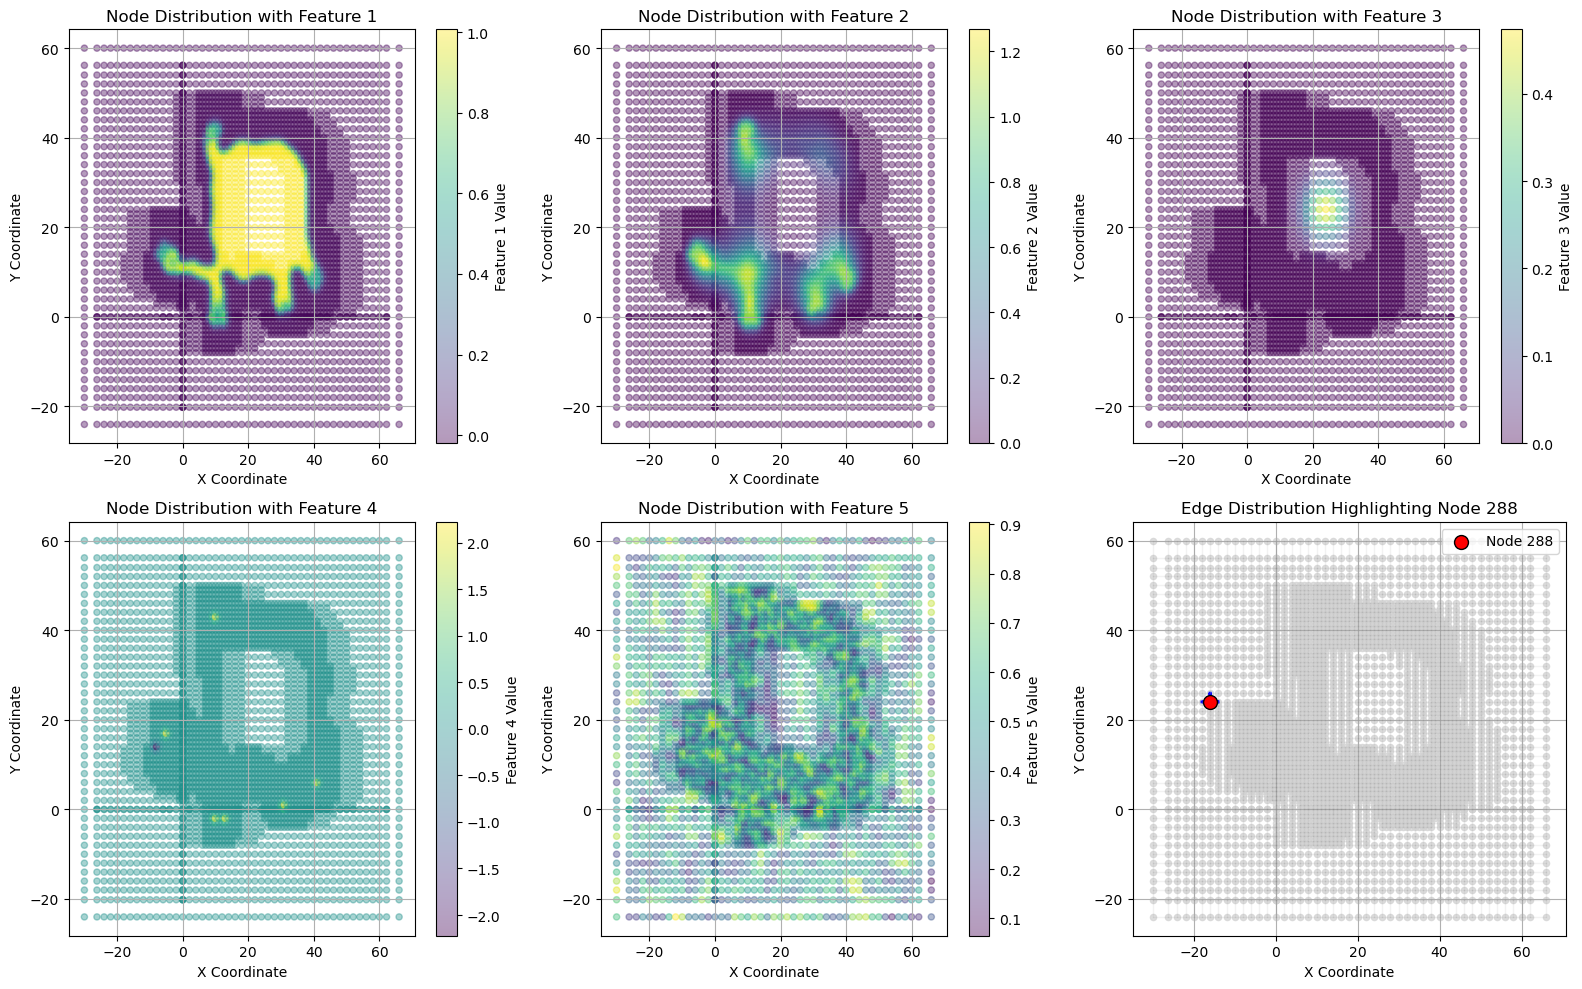

In [8]:
def plot_graph_components_with_highlights(points, features, edges, edge_attr):
    """
    Plots nodes and multiple scalar values in subplots, highlighting in blue the vectors (edges) originating from a randomly selected node,
    based on edge_index, using edge_attr to determine direction and magnitude.

    Args:
        points (numpy.ndarray): Nx2 array of point coordinates.
        features (numpy.ndarray): Array of multiple scalar values associated with each point, dimension NxM.
        edges (numpy.ndarray): Nx2 array of index pairs representing edges.
        edge_attr (torch.Tensor): Tensor containing lengths or vector components for each edge.
    """
    # Generate a random index for the node
    random_node = random.randint(0, len(points) - 1)
    num_features = features.shape[1]

    # Set the number of rows and columns for the subplot grid
    num_columns = 3
    num_rows = (num_features + 1 + num_columns - 1) // num_columns

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(16, 5 * num_rows))
    axs = axs.ravel()  # Flatten the axs array for easier iteration

    # Plot points with scalar values for each feature
    for i in range(num_features):
        scatter = axs[i].scatter(points[:, 0], points[:, 1], c=features[:, i], s=20, alpha=0.4)
        axs[i].set_title(f'Node Distribution with Feature {i+1}')
        axs[i].set_xlabel('X Coordinate')
        axs[i].set_ylabel('Y Coordinate')
        cbar = fig.colorbar(scatter, ax=axs[i])
        cbar.set_label(f'Feature {i+1} Value')
        axs[i].grid(True)

    # Edge distribution plot, highlighting the random node and its connected edges
    edge_ax = axs[num_features]
    edge_ax.scatter(points[:, 0], points[:, 1], c='lightgray', s=20, alpha=0.75)  # Plot all nodes for context

    # Plot all edges
    for index, edge in enumerate(edges):
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        dx = edge_attr[index][0]
        dy = edge_attr[index][1]

        if random_node in edge:
            color = 'blue'
            alpha = 1.0
            linewidth = 2
            edge_ax.arrow(point_a[0], point_a[1], dx, dy, color=color, alpha=alpha, linewidth=linewidth, head_width=0.02, length_includes_head=True)
        else:
            color = 'gray'
            alpha = 0.1
            edge_ax.plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], color=color, alpha=alpha, linewidth=1)

    # Highlight the random node last to ensure it's on top
    edge_ax.scatter(points[random_node, 0], points[random_node, 1], color='red', s=100, edgecolors='black', label=f'Node {random_node}', zorder=5)
    edge_ax.set_title('Edge Distribution Highlighting Node ' + str(random_node))
    edge_ax.set_xlabel('X Coordinate')
    edge_ax.set_ylabel('Y Coordinate')
    edge_ax.legend()
    edge_ax.grid(True)

    # Hide any unused axes if there are any
    for i in range(num_features + 1, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage assuming the data is prepared
random_index = random.randint(0, len(graph_data_list) - 1)
graph_data = graph_data_list[random_index]

points = graph_data.x.numpy()[:, :2]
features = graph_data.x.numpy()[:, 2:]  # All features from index 2 to end
edges = graph_data.edge_index.numpy().T
edge_attr = graph_data.edge_attr.numpy()  # Assuming edge_attr contains vector components for each edge

plot_graph_components_with_highlights(points, features, edges, edge_attr)

In [9]:
def combine_graph_data(graph_data_list):
    """
    Combines multiple graph data objects into a single graph data object.

    Args:
        graph_data_list (list of Data): List of individual graph data objects to be combined.

    Returns:
        Data: A single combined graph data object containing all node features, edges, edge attributes, and target labels.
    """
    # Initialize lists to hold combined data components
    combined_x = []
    combined_edge_index = []
    combined_edge_attr = []
    combined_y = []
    
    node_offset = 0  # Initial offset for node indices

    # Loop through each individual graph data object
    for data in graph_data_list:
        num_nodes = data.x.size(0)  # Number of nodes in the current graph
        
        # Append node features from the current graph
        combined_x.append(data.x)
        
        # Adjust edge indices by the current node offset and append
        adjusted_edge_index = data.edge_index + node_offset
        combined_edge_index.append(adjusted_edge_index)
        
        # Append edge attributes from the current graph
        combined_edge_attr.append(data.edge_attr)
        
        # Append target labels from the current graph
        combined_y.append(data.y)
        
        # Update the node offset for the next graph
        node_offset += num_nodes
    
    # Concatenate lists into tensors to create a single combined graph
    combined_x = torch.cat(combined_x, dim=0)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    combined_edge_attr = torch.cat(combined_edge_attr, dim=0)
    combined_y = torch.cat(combined_y, dim=0)
    
    # Create and return the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=combined_y)
    return combined_data

# Example usage:
# Assuming graph_data_list is a list of PyTorch Geometric Data objects
data = combine_graph_data(graph_data_list)
# data.x = data.x[:,:3]
# Print details about the combined graph data
print("Combined Graph Data:")
print(data)


Combined Graph Data:
Data(x=[8223, 7], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223])


In [10]:
# Function to keep the first 3 and the last channel of features in data.x
def modify_features(data):
    # Select the first three channels (0, 1, 2) and the last channel (-1)
    first_three = data.x[:, :3]  # all rows, first three columns
    last_one = data.x[:, -1:]  # all rows, last column (keep dimension)

    # Concatenate the selected parts along the feature dimension
    new_x = torch.cat([first_three, last_one], dim=1)

    return new_x

# Modify the features in the data object
# data.x = modify_features(data)

# print(data.x)
# data.x = data.x[:, 2]
# print(data.x)
# data.y = data.x
# print(data.y)

# Output the modified data shape to confirm the change
print("Modified feature shape:", data)

Modified feature shape: Data(x=[8223, 7], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223])


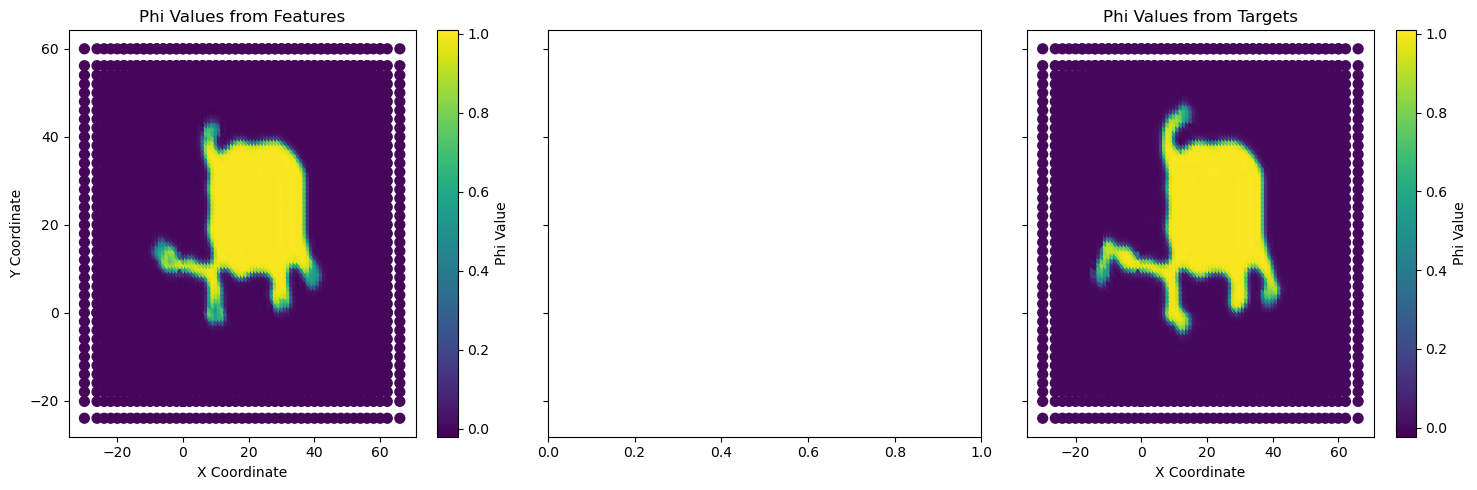

In [11]:
def visualize_graph_data(data):
    """
    Visualizes the coordinates and two sets of 'phi' values for the given graph data object.

    Args:
        data (Data): A PyTorch Geometric Data object containing the graph data.

    Displays:
        Scatter plots with nodes colored according to their 'phi' and 'theta' values from features and targets.
    """
    # Extract x coordinates and feature values from the data
    x_coords = data.x[:, :2].numpy()  # First two columns are coordinates
    phi_values_x = data.x[:, 2].numpy()  # Assuming the third column in x is 'phi'
    # theta_values_x = data.x[:, 6].numpy()  # Assuming the last column in x is 'theta'
    phi_values_y = data.y.numpy()  # 'phi' values used as target variable

    # Create a plot with three subplots for comparison
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # Plot 'phi' from features
    scatter1 = axs[0].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_x, cmap='viridis', s=50)
    axs[0].set_title('Phi Values from Features')
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    fig.colorbar(scatter1, ax=axs[0], label='Phi Value')

    # # Plot 'theta' from features
    # scatter2 = axs[1].scatter(x_coords[:, 0], x_coords[:, 1], c=theta_values_x, cmap='viridis', s=50)
    # axs[1].set_title('Theta Values from Features')
    # axs[1].set_xlabel('X Coordinate')
    # fig.colorbar(scatter2, ax=axs[1], label='Theta Value')

    # Plot 'phi' from targets
    scatter3 = axs[2].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_y, cmap='viridis', s=50)
    axs[2].set_title('Phi Values from Targets')
    axs[2].set_xlabel('X Coordinate')
    fig.colorbar(scatter3, ax=axs[2], label='Phi Value')

    plt.tight_layout()
    plt.show()

visualize_graph_data(data)

In [12]:
def remove_nodes(data, threshold=1e-2):
    """
    Removes nodes based on the condition that the third channel of x for the node and all its connected nodes 
    is close to 0 or close to 1 within a threshold.

    Args:
        data (Data): PyTorch Geometric Data object with attributes x, edge_index, y, and optionally edge_attr.
        threshold (float): Threshold value to determine closeness to zero or one.

    Returns:
        Data: A new PyTorch Geometric Data object with specified nodes removed.
    """
    num_nodes = data.x.size(0)
    # Create an adjacency list to find connected nodes easily
    adjacency_list = [[] for _ in range(num_nodes)]
    for source, target in data.edge_index.t().tolist():
        adjacency_list[source].append(target)
        adjacency_list[target].append(source)  # Assuming undirected graph

    # Check each node and its neighbors
    keep_nodes = torch.ones(num_nodes, dtype=torch.bool)
    phi_values = data.x[:, 2]  # Assume the 'phi' feature is the third column in x
    for idx in range(num_nodes):
        phi_node = phi_values[idx]
        neighbors_phi = phi_values[adjacency_list[idx]]
        # Check if node and all connected nodes are close to 0 or 1
        if not ((torch.abs(phi_node) <= threshold).item() or (torch.abs(phi_node - 1) <= threshold).item()):
            continue  # If central node phi is not close to 0 or 1, keep it
        if torch.all(torch.abs(neighbors_phi) <= threshold) or torch.all(torch.abs(neighbors_phi - 1) <= threshold):
            keep_nodes[idx] = False  # If all neighbors are also close to 0 or 1, mark for removal

    # Filter nodes, edges, and edge attributes
    new_x = data.x[keep_nodes]
    new_y = data.y[keep_nodes]
    kept_node_indices = torch.where(keep_nodes)[0]
    new_indices = torch.full((num_nodes,), -1, dtype=torch.long)
    new_indices[kept_node_indices] = torch.arange(kept_node_indices.size(0))

    # Filter edges to include only those connecting kept nodes
    edge_mask = (new_indices[data.edge_index[0]] != -1) & (new_indices[data.edge_index[1]] != -1)
    new_edge_index = new_indices[data.edge_index[:, edge_mask]]

    new_edge_attr = data.edge_attr[edge_mask] if data.edge_attr is not None else None

    # Create a new data object with the filtered data
    new_data = Data(x=new_x, edge_index=new_edge_index, y=new_y, edge_attr=new_edge_attr)
    return new_data

# Example usage:
# Assuming 'data' is your original PyTorch Geometric data object
print('Before removing nodes based on phi values')
print(data)
# data = remove_nodes(data, threshold=0.01)
# print('After removing nodes based on phi values')
# print(data)


Before removing nodes based on phi values
Data(x=[8223, 7], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223])


In [13]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.float()
# Print the final structured data object
print(data)

Data(x=[8223, 7], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223], train_mask=[8223], test_mask=[8223], val_mask=[8223], num_classes=2)


In [14]:
def min_max_normalize_features(data):
    """
    Normalizes each feature in the data.x tensor and the data.y tensor to be between 0 and 1.
    This function modifies the data.x and data.y attributes of the input data object in-place.

    Args:
        data (torch_geometric.data.Data): The data object containing the x and y attributes
            where data.x is a tensor of shape [N, F] (N is the number of nodes and F is the number of features),
            and data.y is a tensor of shape [N] or [N, 1].

    Returns:
        data (torch_geometric.data.Data): The modified data object with normalized features and target values.
    """
    # Normalize data.x
    min_vals_x = torch.min(data.x, dim=0)[0]
    max_vals_x = torch.max(data.x, dim=0)[0]
    range_vals_x = max_vals_x - min_vals_x
    range_vals_x[range_vals_x == 0] = 1  # Prevent division by zero
    data.x = (data.x - min_vals_x) / range_vals_x

    # Normalize data.y if it's not just binary labels
    if data.y.dim() == 1 or data.y.size(1) > 1:  # Check if data.y is not binary or multi-dimensional
        min_vals_y = torch.min(data.y)
        max_vals_y = torch.max(data.y)
        range_vals_y = max_vals_y - min_vals_y
        if range_vals_y == 0:
            range_vals_y = 1  # Prevent division by zero
        data.y = (data.y - min_vals_y) / range_vals_y

    return data


def add_gradient_features(data, edge_index):
    """
    Adds gradient features to the data.x tensor based on the differences in feature values along edges.
    The gradient is calculated using the pseudo-coordinates stored in edge_attr and added to the node features.

    Args:
        data (torch_geometric.data.Data): The data object containing node features and edge attributes.
        edge_index (torch.Tensor): Tensor containing the indices of source and destination nodes for each edge.

    Returns:
        data (torch_geometric.data.Data): The modified data object with additional gradient features.
    """
    num_features = data.x.shape[1] - 2  # Exclude the coordinate columns
    epsilon = 1e-6  # Small number to prevent division by zero

    for i in range(num_features):
        feature_values = data.x[:, i+2]
        gradients = torch.zeros_like(data.x[:, :2])  # Only two columns for gradient (dx, dy)

        for j, (src, dest) in enumerate(edge_index.t()):
            pseudo_coords = data.edge_attr[j]
            dx, dy = pseudo_coords[0], pseudo_coords[1]  # Assuming pseudo_coords are stored as [dx, dy]

            # Calculate gradient components separately and safely
            gradient_x = (feature_values[dest] - feature_values[src]) / (dx + epsilon)
            gradient_y = (feature_values[dest] - feature_values[src]) / (dy + epsilon)
            
            gradients[src, 0] += gradient_x
            gradients[src, 1] += gradient_y
            gradients[dest, 0] -= gradient_x
            gradients[dest, 1] -= gradient_y  # Symmetric impact

        # Concatenate gradient features to original features
        data.x = torch.cat([data.x, gradients], dim=1)

        print(f"Processed feature {i+1}/{num_features} ({(i+1) / num_features * 100:.1f}%)")

    return data

def rotate_points(data, angle_degrees):
    """
    Rotates the point coordinates in the data.x tensor by a specified angle.

    Args:
        data (torch_geometric.data.Data): The data object containing node features.
        angle_degrees (float): The angle in degrees to rotate the point coordinates.

    Returns:
        data (torch_geometric.data.Data): The modified data object with rotated coordinates.
    """
    angle = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Assume the first two columns in x are coordinates
    coords = data.x[:, :2].numpy()
    new_coords = np.dot(coords, rotation_matrix)
    data.x[:, :2] = torch.tensor(new_coords, dtype=torch.float32)

    print(f"Rotated points by {angle_degrees} degrees.")
    return data

def oversample_minority_class(data):
    """
    Duplicates samples of the minority class in the dataset to balance class distribution.

    Args:
        data (torch_geometric.data.Data): The data object containing node labels and optionally masks.

    Returns:
        data (torch_geometric.data.Data): The modified data object with duplicated minority class samples.
    """
    unique, counts = torch.unique(data.y, return_counts=True)
    minority_class = unique[torch.argmin(counts)]

    # Indices of the minority class
    minority_indices = (data.y == minority_class).nonzero(as_tuple=True)[0]
    
    # Duplicate minority class samples
    minority_x = data.x[minority_indices]
    minority_y = data.y[minority_indices]
    
    # Update the data object
    data.x = torch.cat([data.x, minority_x], dim=0)
    data.y = torch.cat([data.y, minority_y], dim=0)

    # Update masks if they exist
    if hasattr(data, 'train_mask'):
        minority_mask = data.train_mask[minority_indices]
        data.train_mask = torch.cat([data.train_mask, minority_mask], dim=0)
    if hasattr(data, 'test_mask'):
        minority_mask = data.test_mask[minority_indices]
        data.test_mask = torch.cat([data.test_mask, minority_mask], dim=0)
    if hasattr(data, 'val_mask'):
        minority_mask = data.val_mask[minority_indices]
        data.val_mask = torch.cat([data.val_mask, minority_mask], dim=0)
    
    print(f"Duplicating node {idx.item()} for minority class ({minority_class}); Progress: {len(data.y) / len(minority_indices) * 100:.1f}%")
    return data

In [15]:
data.x[:, 2] = np.round(data.x[:, 2], decimals=2)

data.x = data.x[:, :3]

# data.y = np.round(data.y)

In [16]:
# Normalize features
data = min_max_normalize_features(data)

# # Add gradient features
# data = add_gradient_features(data, data.edge_index)
# print('Done adding gradient features')

# # Optionally, rotate points for augmentation
# data = rotate_points(data, 45)  # Rotate by 45 degrees
# print('Done rotating points')

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)
# print('Done oversampling minority class')

# Print data to verify changes
print(data)

Data(x=[8223, 3], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223], train_mask=[8223], test_mask=[8223], val_mask=[8223], num_classes=2)


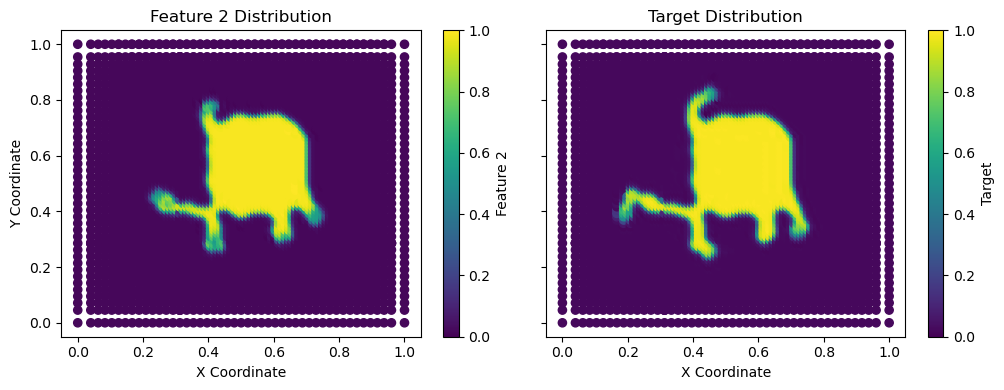

In [17]:
def plot_features_and_target(data):
    """
    Plots each feature and the target variable from the dataset based on the coordinates.

    Args:
        data (torch_geometric.data.Data): The data object containing node features, where
            the first two columns are assumed to be x and y coordinates.

    Displays:
        Scatter plots for each feature and the target variable, colored by their values.
    """
    if data.x is None or data.y is None:
        print("Node features or target values are missing in the dataset.")
        return

    # Coordinates are the first two columns
    coords = data.x[:, :2].numpy()
    num_features = data.x.size(1) - 2  # excluding the coordinate columns

    # Setup plot grid
    num_plots = num_features + 1  # Plus one for the target variable
    cols = 3  # Set number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True, squeeze=False)

    # Plot each feature
    for i in range(num_plots):
        ax = axes[i // cols, i % cols]  # Determine row and column index
        if i < num_features:
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.x[:, i+2].numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label=f'Feature {i+2}')
            ax.set_title(f'Feature {i+2} Distribution')
        else:
            # Plot the target variable
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.y.numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label='Target')
            ax.set_title('Target Distribution')

        ax.set_xlabel('X Coordinate')
        if i % cols == 0:  # Only set y-label on the first column
            ax.set_ylabel('Y Coordinate')

    # Hide empty subplots if any
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

plot_features_and_target(data)

In [18]:
# import numpy as np

# def detect_tips_multi(phi_fine, ids, num_neuron, rows, cols):
#     length = rows * cols
#     phi_sum = np.zeros(length)  # Initialize phi_sum with zeros

#     threshold = 0.25
#     intensity_threshold = 0.1
#     offsetY = cols  # Offset for column in a 1D representation of 2D data
#     phi_threshold = 0.0

#     # Function to simulate cellBoundary condition
#     def cell_boundary(phi, threshold):
#         return 1.0 if phi > threshold else 0.0

#     # Dictionary to store max values for each ID
#     max_values = {}

#     # Iterate with precomputed values and reduced condition checks
#     for i in range(5 * cols, length - 4 * cols):
#         if cell_boundary(phi_fine[i], threshold) > 0 and round(ids[i]) != 9:
#             local_sum = 0
#             for j in range(-4, 5):
#                 for k in range(-4, 5):
#                     index = i + j * offsetY + k
#                     if 0 <= index < length:  # Ensure index is within bounds
#                         rounded_id = round(ids[index])
#                         if rounded_id == round(ids[i]) or rounded_id < 0:
#                             local_sum += cell_boundary(phi_fine[index], intensity_threshold)
            
#             phi_sum[i] = local_sum
#             phi_sum[i] = (cell_boundary(phi_fine[i], phi_threshold) / local_sum) if phi_sum[i] > 0 else 0
#             phi_sum[i] = 0 if np.isnan(phi_sum[i]) else phi_sum[i]  # Handle NaN explicitly

#             # Update max value for each ID
#             id_key = round(ids[i])
#             if id_key not in max_values or max_values[id_key] < phi_sum[i]:
#                 max_values[id_key] = phi_sum[i]

#     # Normalize phi_sum by the max value for each ID and apply thresholding
#     for i in range(length):
#         id_key = round(ids[i])
#         if id_key in max_values and max_values[id_key] != 0:
#             normalized_threshold = 0.825 * max_values[id_key]
#             phi_sum[i] = (phi_sum[i] / max_values[id_key]) if phi_sum[i] >= normalized_threshold else 0.0

#     return phi_sum

# # Example usage:
# # Assuming phi_fine, ids are numpy arrays and num_neuron, rows, cols are integers
# # phi_sum = detect_tips_multi(phi_fine, ids, num_neuron, rows, cols)


In [19]:
# Example check for NaNs in your data
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")

In [20]:
# !mkdir ./generated_data
# # Assuming 'data' is your PyTorch Geometric Data object
# torch.save(data, './generated_data/NDD.pt')
# # Load a single data object
# data = torch.load('./generated_data/NDD_per1000.pt')

In [21]:
print(data)
print(max(data.x[:,1]))
print(data.x)
print(max(data.y))
print(data.y)

Data(x=[8223, 3], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223], train_mask=[8223], test_mask=[8223], val_mask=[8223], num_classes=2)
tensor(1.)
tensor([[0.3125, 0.2857, 0.0194],
        [0.3125, 0.3313, 0.0194],
        [0.3125, 0.3571, 0.0194],
        ...,
        [1.0000, 0.9286, 0.0194],
        [1.0000, 0.9544, 0.0194],
        [1.0000, 1.0000, 0.0194]])
tensor(1.)
tensor([0.0224, 0.0224, 0.0219,  ..., 0.0224, 0.0224, 0.0224])


In [22]:
def print_random_y_values(data):
    """
    Randomly selects and prints 10 values from the data.y tensor.

    Args:
        data (torch_geometric.data.Data): The data object containing the y attribute
            which is a tensor of shape [N] where N is the number of elements.

    """
    num_samples = 20  # Number of samples to print
    num_elements = data.y.size(0)  # Total number of elements in data.y

    # Ensure we don't sample more elements than available
    if num_elements < num_samples:
        num_samples = num_elements

    # Randomly choose indices without replacement
    indices = torch.randperm(num_elements)[:num_samples]

    # Fetch the selected elements
    selected_values = data.y[indices]

    # Print the selected values
    print("Randomly selected data.y values:")
    for index, value in zip(indices, selected_values):
        print(f'Index {index.item()}: {value.item()}')

print_random_y_values(data)


Randomly selected data.y values:
Index 7238: 0.03714670240879059
Index 6154: 0.030718347057700157
Index 150: 0.708224892616272
Index 8011: 0.022403787821531296
Index 7479: 0.018922951072454453
Index 1376: 0.022486912086606026
Index 5805: 0.11068501323461533
Index 5831: 0.0192175954580307
Index 5772: 0.1916252076625824
Index 7595: 0.02226857654750347
Index 1184: 0.02240152284502983
Index 3359: 0.9905800223350525
Index 4566: 0.022403473034501076
Index 676: 0.024215327575802803
Index 7543: 0.022284118458628654
Index 1661: 0.022518696263432503
Index 524: 0.9909250736236572
Index 4962: 0.8507813215255737
Index 7609: 0.022407639771699905
Index 5636: 0.022242898121476173


In [23]:
class SplineCNN_SuperPixelNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # First SplineConv layer
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.pool1 = torch.nn.MaxPool2d(4)  # Pooling layers might not be directly applicable depending on your graph structure

        # Second SplineConv layer
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.pool2 = torch.nn.MaxPool2d(4)

        # Global Average Pooling
        self.glob_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Adjusted to graph's pooled feature dimensions

        # Fully connected layers
        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # First SplineConv layer
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        # Note: MaxPool2d is not directly applicable to graph data without a spatial feature representation

        # Second SplineConv layer
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        # Note: Again, MaxPool2d is not directly applicable here

        # Adjust pooling here to match graph data requirements
        # x = self.glob_avg_pool(x)  # Needs to be adapted if x is not a batched feature map

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x



In [29]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.conv3 = SplineConv(64, 128, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.conv4 = SplineConv(128, 1, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        # self.bn4 = torch.nn.BatchNorm1d(64)
        # self.conv5 = SplineConv(64, 1, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        # self.bn5 = torch.nn.BatchNorm1d(1)


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv4(x, edge_index, edge_attr)
        # x = self.bn4(x)
        x = F.elu(x)
        # x = F.dropout(x, training=self.training, p=0.1)
        # x = self.conv5(x, edge_index, edge_attr)
        # x = self.bn5(x)
        # x = F.elu(x)
        x = torch.sigmoid(x)  # Sigmoid activation to output probabilities
        return x


In [30]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].unsqueeze(1))  # Use MSE loss for continuous output
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    out = model(data)  # Output shape: [num_nodes, 1]
    out = out.squeeze()  # Squeeze to match target shape [num_nodes]

    train_error = F.mse_loss(out[data.train_mask], data.y[data.train_mask]).item()
    test_error = F.mse_loss(out[data.test_mask], data.y[data.test_mask]).item()
    
    return train_error, test_error


In [31]:
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].unsqueeze(1).float())  # Use binary cross entropy loss
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     out = model(data)
#     out = out.squeeze()  # Squeeze to match target shape [num_nodes]
#     # Calculate binary cross-entropy loss for train and test sets
#     train_loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].float()).item()
#     test_loss = F.binary_cross_entropy(out[data.test_mask], data.y[data.test_mask].float()).item()
#     return train_loss, test_loss

In [32]:
print(data)

Data(x=[8223, 3], edge_index=[2, 15899], edge_attr=[15899, 2], y=[8223], train_mask=[8223], test_mask=[8223], val_mask=[8223], num_classes=2)


In [33]:
# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# GPU Memory Monitoring Function
def print_gpu_memory(device):
    torch.cuda.synchronize(device)
    allocated = torch.cuda.memory_allocated(device)
    reserved = torch.cuda.memory_reserved(device)
    print(f"Allocated memory: {allocated / (1024**3):.3f} GB")
    print(f"Reserved memory: {reserved / (1024**3):.3f} GB")

# Initialize the Net model
# model = SplineCNN_SuperPixelNet(data)
model = Net(data)  # Instantiate the model with the data

# Initialize weights
def weights_init(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, SplineConv):
        torch.nn.init.xavier_uniform_(m.weight.data)

# Apply the weights initialization
model.apply(weights_init)

# Move to the appropriate device
model = model.to(device)
data = data.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 101):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')
    if epoch % 20 == 0:
        print_gpu_memory(torch.device('cuda:0'))

cuda


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


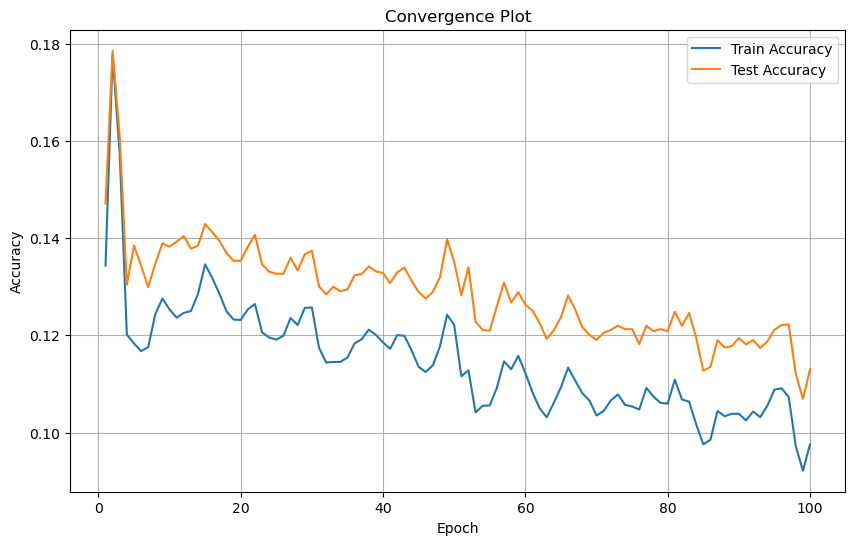

In [ ]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 101), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    
    # Calculate Mean Squared Error
    mse = F.mse_loss(out[data.test_mask], actual)
    
    print(f'Test MSE: {mse.item():.4f}')
    
    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(10, out[data.test_mask].size(0))
    for i in range(num_samples):
        print(f'Predicted: {out[data.test_mask][i].item():.4f}, Actual: {actual[i].item():.4f}')

evaluate_model_regression(data, model)


Test MSE: 0.2406

Sample Predictions:
Predicted: 0.3690, Actual: 0.0012
Predicted: 0.3700, Actual: 0.0012
Predicted: 0.3815, Actual: 0.0005
Predicted: 0.3831, Actual: 0.0005
Predicted: 0.3697, Actual: 0.0008
Predicted: 0.3635, Actual: 0.0004
Predicted: 0.3580, Actual: 0.0012
Predicted: 0.3575, Actual: 0.0012
Predicted: 0.3650, Actual: 0.0011
Predicted: 0.3557, Actual: 0.0004


C:\Users\Kuanr\AppData\Local\Temp\ipykernel_30152\3850080308.py:9: UserWarning: Using a target size (torch.Size([190])) that is different to the input size (torch.Size([190, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out[data.test_mask], actual)


Test Accuracy (sampled): 0.9158 for 1000 samples


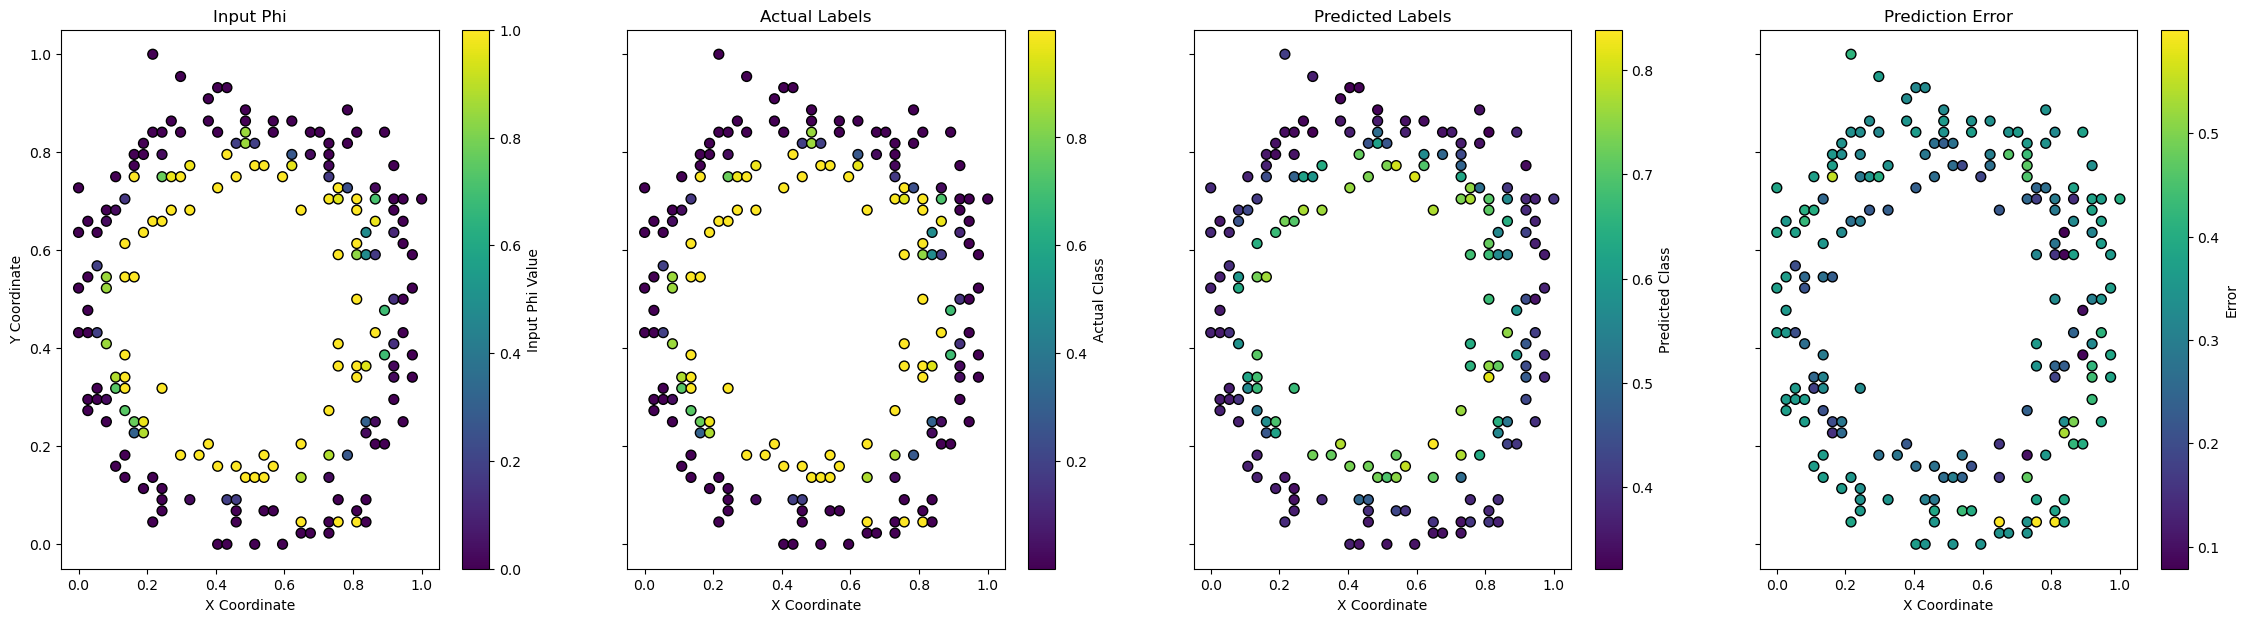

In [ ]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45, num_samples=100):
    model.eval()
    out = model(data)
    
    # Get all test indices
    test_indices = torch.where(data.test_mask)[0]
    
    # Randomly sample from the test indices if the number is greater than num_samples
    if len(test_indices) > num_samples:
        sampled_indices = test_indices[torch.randperm(len(test_indices))[:num_samples]]
    else:
        sampled_indices = test_indices

    pred = out[sampled_indices].squeeze()  # Ensure pred is squeezed to remove extra dimensions
    actual = data.y[sampled_indices]
    input_phi = data.x[sampled_indices, 2]  # Assuming the third column is phi
    error = (pred - actual).abs()  # Calculate error as absolute difference

    # Calculate accuracy for the sampled cases
    correct = pred.round().eq(actual.round()).sum().item()
    total = len(sampled_indices)
    accuracy = correct / total
    print(f'Test Accuracy (sampled): {accuracy:.4f} for {num_samples} samples')

    # Reverse the rotation for visualization purposes
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

    coords = data.x[sampled_indices][:, :2].cpu().numpy()  # Ensure the first two columns are coordinates
    new_coords = np.dot(coords, rotation_matrix)

    # Visualization of 2D predictions
    fig, ax = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=input_phi.cpu().numpy(), cmap='viridis', edgecolor='k', s=50)
    ax[0].set_title('Input Phi')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Input Phi Value')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=actual.cpu().numpy(), cmap='viridis', edgecolor='k', s=50)
    ax[1].set_title('Actual Labels')
    ax[1].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Actual Class')

    scatter = ax[2].scatter(new_coords[:, 0], new_coords[:, 1], c=pred.cpu().numpy(), cmap='viridis', edgecolor='k', s=50)
    ax[2].set_title('Predicted Labels')
    ax[2].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[2], label='Predicted Class')

    # Error visualization
    scatter = ax[3].scatter(new_coords[:, 0], new_coords[:, 1], c=error.cpu().numpy(), cmap='viridis', edgecolor='k', s=50)
    ax[3].set_title('Prediction Error')
    ax[3].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[3], label='Error')

    plt.show()

evaluate_model(data, model, 0, num_samples=1000)
